<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/discharge_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dataretrieval

In [3]:
# !pip install netCDF4
import xarray as xr
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt
import datetime
import glob
from tqdm import tqdm
from scipy.stats import lognorm, linregress
from dataretrieval import nwis

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
merit_centerlines = gpd.read_file('/content/drive/MyDrive/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01.shp').to_crs(3857)

<Axes: >

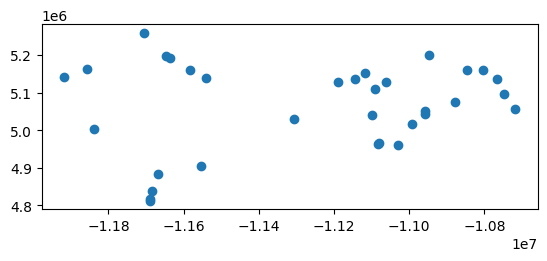

In [9]:
gage_list = ['06764880', '06775900', '06775500', '06770200', '06767970', '06768000',
             '06784000', '06781900', '06785000', '06790500', '06800500', '06793000',
             '06800000', '06777495', '06786000', '06799350', '06799315', '06799000',
             '06797500', '06785500', '06710247', '06711565', '06714215', '06721000',
             '06759500', '06620000', '06680500', '06630000', '06674500', '06635000',
             '06670500', '06657000', '06652000']


gage_gdf = nwis.get_info(sites=gage_list)[0][['site_no', 'geometry']]
gage_gdf = gpd.GeoDataFrame(gage_gdf, geometry=gage_gdf.geometry, crs=4269)\
    .to_crs(3857)

gage_gdf.plot()

<Axes: >

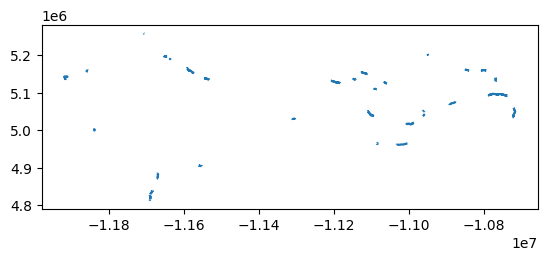

In [10]:
gage_merits = gpd.sjoin_nearest(gage_gdf, merit_centerlines, distance_col='mg_dist')
gage_merits = pd.merge(gage_merits.rename(columns={'geometry': 'pointgeom'}), merit_centerlines[['COMID', 'geometry']].rename(columns={'geometry': 'linegeom'}), on='COMID')
gage_merits = gage_merits.set_geometry('linegeom')
gage_merits.plot()

In [11]:
gage_Q = nwis.get_dv(sites=gage_list, start='2018-01-01', end='2024-12-31', parameterCd='00060')[0]
gage_Q['00060_Mean'] = gage_Q['00060_Mean'] * (3.28 ** -3)
gage_Q = gage_Q.rename(columns={'00060_Mean': 'Q_cms', '00060_Mean_cd': 'Q_cd'}).reset_index()

gage_Q['date'] = pd.to_datetime(gage_Q.datetime).dt.date
gage_Q = gage_Q.loc[gage_Q.Q_cd == 'A']
gage_Q = gage_Q[['site_no', 'Q_cms', 'date']]

gage_Q = pd.merge(gage_Q, gage_merits, how='left', on='site_no')

gage_Q = gpd.GeoDataFrame(gage_Q, geometry=gage_Q.linegeom, crs=3857)

gage_Q

,site_no,Q_cms,date,pointgeom,index_right,COMID,lengthkm,lengthdir,sinuosity,slope,...,slope_taud,NextDownID,maxup,up1,up2,up3,up4,mg_dist,linegeom,geometry
0,06620000,9.323401,2018-03-24,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
1,06620000,12.128923,2018-03-25,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
2,06620000,12.355632,2018-03-26,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
3,06620000,11.023717,2018-03-27,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
4,06620000,9.748480,2018-03-28,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67799,06800500,30.038921,2024-12-27,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."
67800,06800500,32.306010,2024-12-28,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."
67801,06800500,33.439554,2024-12-29,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."
67802,06800500,35.990028,2024-12-30,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."


<Axes: >

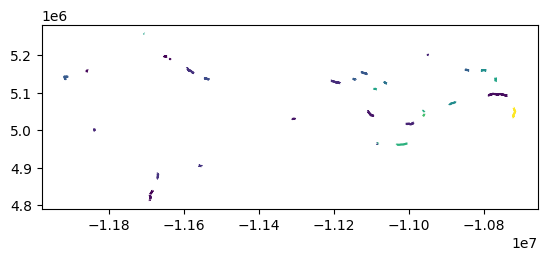

In [12]:
gage_stats = gage_Q.groupby('site_no').agg(
    mean_Q_usgs = ('Q_cms', lambda x: np.mean(x)),
    median_Q_usgs = ('Q_cms', lambda x: np.median(x)),
    iqr_Q_usgs = ('Q_cms', lambda x: np.percentile(x, 75) - np.percentile(x, 25)),
    cqv_Q_usgs = ('Q_cms', lambda x: (np.percentile(x, 75) - np.percentile(x, 25)) / (np.percentile(x, 75) + np.percentile(x, 25))),
    sd_Q_usgs = ('Q_cms', lambda x: np.std(x))
)

gage_stats = pd.merge(gage_stats, gage_merits, how='left', on='site_no')

gage_stats = gpd.GeoDataFrame(gage_stats, geometry=gage_stats.linegeom, crs=3857)

gage_stats.plot(column='median_Q_usgs')

In [14]:
Q2024 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc')
Q2023 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2023.nc')
Q2022 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2022.nc')
Q2021 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2021.nc')
Q2020 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2020.nc')
Q2019 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2019.nc')
Q2018 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2018.nc')

In [15]:
COMID_arr = gage_merits.COMID.unique()

Q2024 = Q2024.sel(rivid=COMID_arr)
Q2023 = Q2023.sel(rivid=COMID_arr)
Q2022 = Q2022.sel(rivid=COMID_arr)
Q2021 = Q2021.sel(rivid=COMID_arr)
Q2020 = Q2020.sel(rivid=COMID_arr)
Q2019 = Q2019.sel(rivid=COMID_arr)
Q2018 = Q2018.sel(rivid=COMID_arr)

all_GRADES = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')

/tmp/ipython-input-3726882691.py:11: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  all_GRADES = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')


In [16]:
GRADES_df = all_GRADES.to_dataframe()\
    .reset_index()\
    .drop('nerr', axis=1)\
    .drop_duplicates(['time', 'rivid'])\
    .rename(columns={'time': 'date', 'rivid': 'COMID'})

GRADES_df.COMID = np.uint32(GRADES_df.COMID)

GRADES_df.date = pd.to_datetime(GRADES_df.date).dt.date

GRADES_df = GRADES_df.set_index(['date', 'COMID'])

GRADES_df

Qout      Qout_err           crs           lon  \
date       COMID                                                           
2018-01-01 74031543   9.433120           NaN           NaN  9.969210e+36   
           74026787  19.832386           NaN           NaN  9.969210e+36   
           74024972   0.014052           NaN           NaN  9.969210e+36   
           74022395  28.811483           NaN           NaN  9.969210e+36   
           74024472  29.278721           NaN           NaN  9.969210e+36   
...                        ...           ...           ...           ...   
2024-12-31 74026765   7.283047  9.969210e+36 -2.147484e+09  9.969210e+36   
           74026718  10.945940  9.969210e+36 -2.147484e+09  9.969210e+36   
           74026714  11.411186  9.969210e+36 -2.147484e+09  9.969210e+36   
           74027435   1.224844  9.969210e+36 -2.147484e+09  9.969210e+36   
           74028970  16.813606  9.969210e+36 -2.147484e+09  9.969210e+36   

                              lat  
date       COMID                   
2018-01-01 74031543  9.969210e+36  
           74026787  9.969210e+36  
           74024972  9.969210e+36  
           74022395  9.969210e+36  
           74024472  9.969210e+36  
...                           ...  
2024-12-31 74026765  9.969210e+36  
           74026718  9.969210e+36  
           74026714  9.969210e+36  
           74027435  9.969210e+36  
           74028970  9.969210e+36  

[84381 rows x 5 columns]

In [17]:
GRADES_USGS = pd.merge(
    gage_Q.set_index(['date', 'COMID'])[['site_no', 'Q_cms', 'lengthkm', 'pointgeom', 'linegeom']],
    GRADES_df[['Qout']],
    on=['date', 'COMID'],
    how='inner'
)

GRADES_USGS

,,site_no,Q_cms,lengthkm,pointgeom,linegeom,Qout
date,COMID,,,,,,
2018-03-24,74031543,06620000,9.323401,6.781344,POINT (-11837624.972 5003000.402),"LINESTRING (-11837807.417 5004232.558, -118379...",11.332474
2018-03-25,74031543,06620000,12.128923,6.781344,POINT (-11837624.972 5003000.402),"LINESTRING (-11837807.417 5004232.558, -118379...",11.550306
2018-03-26,74031543,06620000,12.355632,6.781344,POINT (-11837624.972 5003000.402),"LINESTRING (-11837807.417 5004232.558, -118379...",11.305742
2018-03-27,74031543,06620000,11.023717,6.781344,POINT (-11837624.972 5003000.402),"LINESTRING (-11837807.417 5004232.558, -118379...",11.088330
2018-03-28,74031543,06620000,9.748480,6.781344,POINT (-11837624.972 5003000.402),"LINESTRING (-11837807.417 5004232.558, -118379...",11.054161
...,...,...,...,...,...,...,...
2024-12-27,74028970,06800500,30.038921,26.709834,POINT (-10718273.484 5055705.013),"LINESTRING (-10722200.587 5035231.081, -107221...",15.630909
2024-12-28,74028970,06800500,32.306010,26.709834,POINT (-10718273.484 5055705.013),"LINESTRING (-10722200.587 5035231.081, -107221...",15.713238
2024-12-29,74028970,06800500,33.439554,26.709834,POINT (-10718273.484 5055705.013),"LINESTRING (-10722200.587 5035231.081, -107221...",16.033401


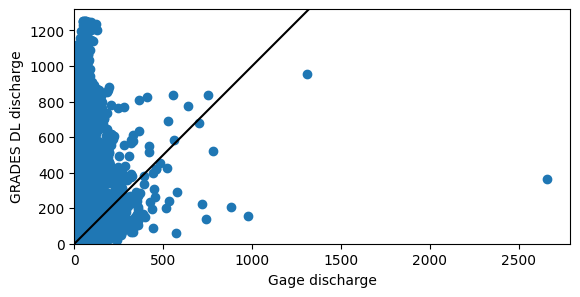

In [18]:
fig, ax = plt.subplots()
ax.scatter(GRADES_USGS.Q_cms, GRADES_USGS.Qout)
ax.set_xlabel('Gage discharge')
ax.set_ylabel('GRADES DL discharge')
ax.set_aspect('equal')
ax.set_xlim(0)
ax.set_ylim(0)
ax.axline((0, 0), slope=1, color='black')

In [34]:
GRFR = xr.open_dataset('/content/drive/MyDrive/GRFR/output_pfaf_07_1979-2019.nc')

GRFR_1819 = GRFR.sel(time=slice('2018-01-01', '2024-12-31'), rivid=COMID_arr)

In [35]:
GRFR_1819 = GRFR_1819\
    .to_dataframe()\
    .reset_index()\
    .drop_duplicates(['time', 'rivid'])\
    .rename(columns={'time': 'date', 'rivid': 'COMID', 'Qout': 'GRFR_Q'})\

GRFR_1819.date = pd.to_datetime(GRFR_1819.date).dt.date

GRFR_1819 = GRFR_1819.set_index(['date', 'COMID'])

In [36]:
GRFR_1819

GRFR_Q
date       COMID              
2018-01-01 74031543   7.411584
           74026787  10.631947
           74024972   0.001758
           74022395  18.599724
           74024472  15.635729
...                        ...
2019-12-31 74026765   8.347904
           74026718  19.124763
           74026714  19.922815
           74027435   9.428254
           74028970  48.290920

[24090 rows x 1 columns]

In [37]:
GRADES_USGS_GRFR = pd.merge(GRADES_USGS, GRFR_1819, on=['date', 'COMID'])

(0.0, 1346.6210246283445)

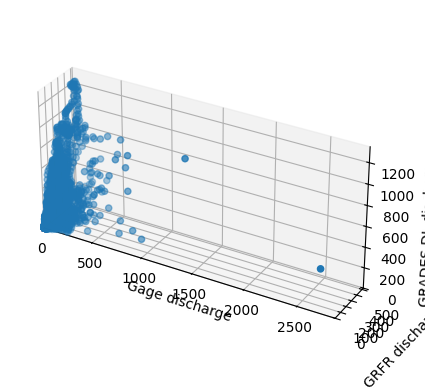

In [42]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.scatter(GRADES_USGS_GRFR.Q_cms, GRADES_USGS_GRFR.GRFR_Q, GRADES_USGS_GRFR.Qout)
ax.set_xlabel('Gage discharge')
ax.set_ylabel('GRFR discharge')
ax.set_zlabel('GRADES DL discharge')
ax.set_aspect('equal')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_zlim(0)
# ax.axline((0, 0), slope=1, color='black')